In [82]:
from src.utils import text_preprocessing
import numpy as np
import pandas as pd

In [83]:
df_train = pd.read_csv('data/train.csv')
with open('data/provided_data/test_shuffle.txt', 'r') as f:
    test_data = f.readlines()
test_data = [text.strip() for text in test_data]
df_test = pd.DataFrame(test_data, columns=['text'])

In [84]:
# count duplicates
print('test duplicates:', df_test.duplicated().sum())

test duplicates: 48


## Patterns to deal with before classifying.

We have noticed 3 mayor patterns on the data that induce errors. Let's deal with them before going any further.

- There are many sentences that begin with "the benefits of [1] are [2]".

In this case [1] specifies the subject of discussion, so we are going to drop the rest

- There are also many sentences that begin with "the impact of [1] on [2]"

In this case [1] specifies the causal factor, even if [2] could give a lot of context, we are dropping it because the first targetted subject is [1]

- Finally the sentences like "the importance of [1] in [2]"

In this case [2] refers to the context. We are keeping [2]

In [85]:
X_test = df_test['text'].values.tolist()

{'The art': 11, 'The American': 29, 'The film': 11, 'The importance': 150, 'The best': 30, 'The impact': 226, 'The link': 16, 'The sports': 38, 'The World': 13, 'The president': 11, 'The benefits': 262}
797


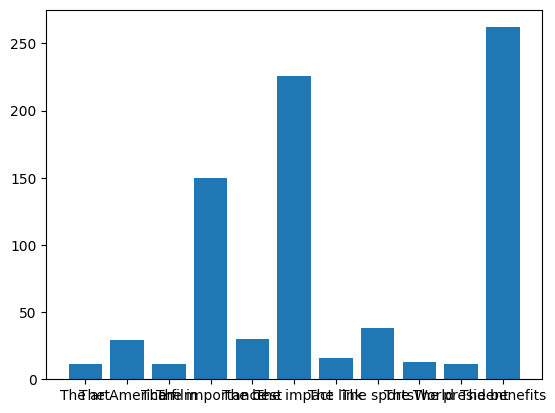

In [86]:
# clusterize sentences based on how they begin
begining_words = [" ".join(sentence.split()[:2]) for sentence in X_test]
count_begining_words = {word:begining_words.count(word) for word in set(begining_words)}
# Display histogram of begining words
import matplotlib.pyplot as plt
high_freq_words = {k: v for k, v in count_begining_words.items() if v > 10}
plt.bar(high_freq_words.keys(), high_freq_words.values())
print(high_freq_words)
print(sum(high_freq_words.values()))

In [87]:
def process_begining_patterns(sentences):
    begining_words_to_remove = {'The benefits':' are ', 'The impact':' on ', 'The importance':' in '}
    which_size_to_pick = {'The benefits': 0, 'The impact': 0, 'The importance': 1}
    processed_sentences = []
    for sentence in sentences:
        any_begining_word = False
        for word in begining_words_to_remove.keys():
            if " ".join(sentence.split()[:2]) == word:
                any_begining_word = True
                if word != 'The importance':
                    beginning_sentence = sentence.split(begining_words_to_remove[word])[which_size_to_pick[word]]
                else:
                    try:
                        beginning_sentence = sentence.split(begining_words_to_remove[word])[which_size_to_pick[word]]
                        beginning_sentence = beginning_sentence.split('cannot')[0]
                    except:
                        # For importance, there are some sentences that do not have the word 'in', in this case replace by 'cannot'
                        beginning_sentence = sentence.split('cannot')[0]
                processed_sentences.append(beginning_sentence.replace(word, '').strip())
        if not any_begining_word:
            processed_sentences.append(sentence)
            
    return processed_sentences

In [88]:
X_test_preprocessed = process_begining_patterns(X_test)

In [89]:
# Prepare dataset
X_train = df_train['text'].values.tolist()
y_train = df_train['label'].values.tolist()
X_processed_train = text_preprocessing(process_begining_patterns(X_train))
y_train = [label.strip() for label in y_train]

X_processed_test = text_preprocessing(X_test_preprocessed)


In [90]:
labels = np.unique(y_train)

In [91]:
labels_processed = { label:text_preprocessing([label])[0] for label in labels}

## Simple topic classification

In [92]:
multiple_labels_sentences = []
single_label_sentences = []
for i,sentence in enumerate(X_processed_test):
    identified_labels = []
    for label in labels:
        if labels_processed[label] in list(sentence.split()):
            identified_labels += [label]
    if len(identified_labels)>1:
        multiple_labels_sentences += [{'text':X_test[i],'processed_text':sentence, 'labels':identified_labels} ]
    elif len(identified_labels) ==1:
        single_label_sentences += [{'text':X_test[i],'processed_text':sentence, 'label':identified_labels[0]} ]


In [93]:
multiple_labels_sentences = pd.DataFrame(multiple_labels_sentences)
print(f"There are {len(multiple_labels_sentences)} sentences with multiple labels")
single_label_sentences = pd.DataFrame(single_label_sentences)
print(f"There are {len(single_label_sentences)} sentences with single labels")

There are 6 sentences with multiple labels
There are 295 sentences with single labels


In [94]:
label = labels[5]
print(f"Sentences with label {label}")
print(f"There are {len(single_label_sentences[single_label_sentences['label']==label])} sentences with label {label}")
display(single_label_sentences[single_label_sentences['label']==label][["label","text","processed_text"]].head(30).to_records(index=False))

Sentences with label Food
There are 58 sentences with label Food


rec.array([('Food', 'The impact of food deserts on community health is a topic of concern.', 'food desert'),
           ('Food', 'The importance of food affordability cannot be overemphasized.', 'food affordability'),
           ('Food', 'The best way to find the best local food tours is to do your research ahead of time.', 'find local food tour research ahead time'),
           ('Food', 'The importance of food justice cannot be overstated.', 'food justice'),
           ('Food', 'The impact of food trends on nutrition is a topic of concern.', 'food trend'),
           ('Food', 'The importance of food traceability cannot be overemphasized.', 'food traceability'),
           ('Food', 'The benefits of eating locally sourced food are many, including freshness and sustainability.', 'eating locally sourced food'),
           ('Food', 'The impact of food additives on liver function is a topic of ongoing debate.', 'food additive'),
           ('Food', 'The impact of food additives on metabolis

We can see it works very well for labels [ Education , Fashion, Food, Health, Sports,Technology, Travel]. 

In [95]:
display(multiple_labels_sentences[["labels","text","processed_text"]].to_dict('records'))

[{'labels': ['Science', 'Sports'],
  'text': 'The sports science research center collaborates with universities on cutting-edge studies.',
  'processed_text': 'sport science research center collaborates university cutting edge study'},
 {'labels': ['Science', 'Sports'],
  'text': 'The sports science lab conducts research to improve athletic performance.',
  'processed_text': 'sport science lab conduct research improve athletic performance'},
 {'labels': ['Education', 'Technology'],
  'text': 'Virtual reality technology is becoming increasingly popular for gaming and education.',
  'processed_text': 'virtual reality technology increasingly popular gaming education'},
 {'labels': ['Finance', 'Politics'],
  'text': 'The tax code is a complex and often controversial topic in finance and politics.',
  'processed_text': 'tax code complex controversial topic finance politics'},
 {'labels': ['Fashion', 'Technology'],
  'text': 'The benefits of using blockchain technology in fashion are many, i

For the multiple labelled, there are only 6 so let's fix them manually

In [15]:
treated_multiple_label_sentences = pd.DataFrame([{'label': 'Science',
  'text': 'The sports science research center collaborates with universities on cutting-edge studies.',
  'processed_text': 'sport science research center collaborates university cutting edge study'},
 {'label': 'Sports',
  'text': 'The sports science lab conducts research to improve athletic performance.',
  'processed_text': 'sport science lab conduct research improve athletic performance'},
 {'label': 'Technology',
  'text': 'Virtual reality technology is becoming increasingly popular for gaming and education.',
  'processed_text': 'virtual reality technology increasingly popular gaming education'},
 {'label': 'Politics',
  'text': 'The tax code is a complex and often controversial topic in finance and politics.',
  'processed_text': 'tax code complex controversial topic finance politics'},
 {'label':  'Technology',
  'text': 'The benefits of using blockchain technology in fashion are many, including improved transparency and traceability.',
  'processed_text': 'blockchain technology fashion'},
 {'label': 'Education',
  'text': 'The importance of food education cannot be overstated.',
  'processed_text': 'food education'}])

single_label_sentences = pd.concat([single_label_sentences, treated_multiple_label_sentences], ignore_index=True)

In [96]:
lefted_sentences = [sentence for sentence in X_processed_test if sentence not in single_label_sentences['processed_text'].values.tolist()]

In [17]:
len(lefted_sentences)

839

## Embed all the words from lefted sentences with Word2Vec

We believe there are other discriminant words that could allow us to classify some other sentences using the same approach. So let's do it!

In [19]:
import gensim.downloader

# google_news = gensim.downloader.load('word2vec-google-news-300')
fast_text_model = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [97]:
# Extract all the words from lefted sentences
all_words = []
for sentence in lefted_sentences:
    all_words += sentence.split()
all_words = [word.strip() for word in all_words if word.strip() != '']
unique_words = list(set(all_words))
for word in unique_words.copy():
    if word not in fast_text_model.index_to_key:
        print(word)
        unique_words.remove(word)

mlps
gmos
covid
fodmap
overtourism


In [98]:
vectors = []
for word in unique_words:
    vectors.append(fast_text_model[word])
vectors_df = pd.DataFrame({'word':unique_words, 'vector':vectors})
vectors_df["count"] = vectors_df["word"].apply(lambda x: all_words.count(x))

In [99]:
from sklearn.metrics.pairwise import cosine_similarity
# Compute the top 10 most similar words per label
most_similar_words = {}
for label in labels:
    label_vector = fast_text_model[labels_processed[label]]
    vectors_df["similarity"] = vectors_df["vector"].apply(lambda x: cosine_similarity([label_vector], [x])[0][0])
    most_similar = vectors_df.sort_values(by='similarity', ascending=False).head(20).copy()
    most_similar_words[label] = most_similar[["word", "similarity","count"]].values.tolist()


In [100]:
label = labels[9]
print(label)
most_similar_words[label]
# Select the most similar words 

Sports


[['sport', 1.0, 2],
 ['football', 0.7231776714324951, 2],
 ['soccer', 0.681702733039856, 7],
 ['athletic', 0.6683861017227173, 1],
 ['athlete', 0.6602561473846436, 6],
 ['motorsports', 0.6535442471504211, 2],
 ['cricket', 0.6493377685546875, 2],
 ['hockey', 0.6426032185554504, 2],
 ['sportsmanship', 0.6306968331336975, 1],
 ['basketball', 0.6286279559135437, 5],
 ['baseball', 0.624761700630188, 2],
 ['gymnastics', 0.6243678331375122, 1],
 ['tennis', 0.6225250959396362, 2],
 ['cycling', 0.6125925779342651, 1],
 ['wrestling', 0.6031221151351929, 1],
 ['archery', 0.5905810594558716, 1],
 ['swimming', 0.587506115436554, 1],
 ['golf', 0.585693895816803, 2],
 ['game', 0.5835121870040894, 9],
 ['rowing', 0.5820471048355103, 1]]

In [101]:
similar_discriminant_words = {
    'Education':['educational','student'],
    'Entertainment':['film','movie','music','television','show','comedian'],
    'Environment':['climate','pollution','energy','sustainability'],
    'Finance':['investing','investor','market'],
    'Health':['healthcare'],
    'Food':['diet','eating'],
    'Politics':['political','prime','minister','president','government','mayor','supreme'],
    'Sports':[line[0] for line in most_similar_words['Sports'][:-4]],
    'Science':['scientist','scientific'],
    'Technology':['tech','software'],
    'Travel':['traveling'],
}

In [102]:
multiple_labels_sentences_discriminant_words = []
single_label_sentences_discriminant_words = []
for i,sentence in enumerate(X_processed_test):
    if sentence in lefted_sentences:
        identified_labels = []
        for label in similar_discriminant_words.keys():
            for word in similar_discriminant_words[label]:
                if word in sentence.split():
                    identified_labels += [label]
                    break
        if len(identified_labels)>1:
            multiple_labels_sentences_discriminant_words += [{'text':X_test[i],'processed_text':sentence, 'labels':identified_labels} ]
        elif len(identified_labels) ==1:
            single_label_sentences_discriminant_words += [{'text':X_test[i],'processed_text':sentence, 'label':identified_labels[0]} ]


In [103]:
multiple_labels_sentences_discriminant_words = pd.DataFrame(multiple_labels_sentences_discriminant_words)
print(f"There are {len(multiple_labels_sentences_discriminant_words)} sentences with multiple labels")
single_label_sentences_discriminant_words = pd.DataFrame(single_label_sentences_discriminant_words)
print(f"There are {len(single_label_sentences_discriminant_words)} sentences with single labels")

There are 13 sentences with multiple labels
There are 367 sentences with single labels


In [104]:
label = labels[5]
print(f"Sentences with label {label}")
print(f"There are {len(single_label_sentences_discriminant_words[single_label_sentences_discriminant_words['label']==label])} sentences with label {label}")
display(single_label_sentences_discriminant_words[single_label_sentences_discriminant_words['label']==label][["label","text","processed_text"]].head(30).to_records(index=False))

Sentences with label Food
There are 45 sentences with label Food


rec.array([('Food', 'The American Heart Association recommends a diet low in sodium to reduce the risk of high blood pressure.', 'american heart association recommends diet low sodium reduce risk high blood pressure'),
           ('Food', 'The American Diabetes Association recommends regular exercise and a healthy diet to manage blood sugar levels.', 'american diabetes association recommends regular exercise healthy diet manage blood sugar level'),
           ('Food', 'The benefits of eating a flexitarian diet are many, including improved health and reduced environmental impact.', 'eating flexitarian diet'),
           ('Food', 'The benefits of eating a low-salt diet are many, including reduced blood pressure and improved heart health.', 'eating low salt diet'),
           ('Food', 'The benefits of eating a low-FODMAP diet are many, including improved digestion and reduced bloating.', 'eating low fodmap diet'),
           ('Food', 'The benefits of eating a vegetarian diet are many, inc

All the singled labelled instances seem to be correctly labelled. There are only 10 sentences with multiple labels so let's treat them manually.

In [105]:
display(multiple_labels_sentences_discriminant_words[["labels","text","processed_text"]].to_dict('records'))

[{'labels': ['Environment', 'Politics'],
  'text': 'The political climate is becoming increasingly tense.',
  'processed_text': 'political climate increasingly tense'},
 {'labels': ['Environment', 'Politics'],
  'text': 'The political climate is becoming increasingly hostile.',
  'processed_text': 'political climate increasingly hostile'},
 {'labels': ['Environment', 'Science'],
  'text': 'Scientists have developed a new renewable energy source.',
  'processed_text': 'scientist developed renewable energy source'},
 {'labels': ['Entertainment', 'Politics'],
  'text': "The comedian's stand-up special tackles social and political issues with humor.",
  'processed_text': 'comedian stand special tackle social political issue humor'},
 {'labels': ['Finance', 'Technology'],
  'text': 'The tech entrepreneur pitched their startup idea to investors at a venture capital firm.',
  'processed_text': 'tech entrepreneur pitched startup idea investor venture capital firm'},
 {'labels': ['Entertainment

In [106]:
treated_multiple_label_sentences_discriminant_words = pd.DataFrame([{'label': 'Politics',
  'text': 'The political climate is becoming increasingly tense.',
  'processed_text': 'political climate increasingly tense'},
 {'label': 'Politics',
  'text': 'The political climate is becoming increasingly hostile.',
  'processed_text': 'political climate increasingly hostile'},
 {'label': 'Entertainment', 
  'text': "The comedian's stand-up special tackles social and political issues with humor.",
  'processed_text': 'comedian stand special tackle social political issue humor'},
 {'label': 'Technology',
  'text': 'The tech entrepreneur pitched their startup idea to investors at a venture capital firm.',
  'processed_text': 'tech entrepreneur pitched startup idea investor venture capital firm'},
 {'label': 'Entertainment', 
  'text': 'The talk show host interviewed political figures and celebrities alike.',
  'processed_text': 'talk show host interviewed political figure celebrity alike'},
 {'label': 'Health', 
  'text': 'The benefits of eating a plant-based diet for athletes are many, including improved recovery and reduced inflammation.',
  'processed_text': 'eating plant based diet athlete'},
 {'label': 'Politics',
  'text': 'The prime minister has announced a new plan to improve the healthcare system.',
  'processed_text': 'prime minister announced plan improve healthcare system'},
 {'label': 'Politics',
  'text': 'The president has announced a new plan to address climate change.',
  'processed_text': 'president announced plan address climate change'},
 {'label': 'Politics',
  'text': 'The political climate is becoming increasingly divisive.',
  'processed_text': 'political climate increasingly divisive'},
 {'label': 'Politics',
  'text': 'The political climate is becoming increasingly polarized.',
  'processed_text': 'political climate increasingly polarized'},
 {'label': 'Education',
  'text': 'The coding bootcamp teaches students programming languages and software development skills.',
  'processed_text': 'coding bootcamp teach student programming language software development skill'},
  {'label':'Science',
  'text': 'Scientists have developed a new renewable energy source.',
  'processed_text': 'scientist developed renewable energy source'},
  {'label': 'Finance',
  'text': 'The benefits of investing in renewable energy are becoming increasingly clear.',
  'processed_text': 'investing renewable energy'}])

single_label_sentences_discriminant_words = pd.concat([single_label_sentences_discriminant_words, treated_multiple_label_sentences_discriminant_words], ignore_index=True) 

Finally we add one last patter we identified, sentences with "The best way to find the best" are classified in Travel

In [107]:
pattern = "The best way to"
label = "Travel"
pattern_classification = []
for i,sentence in enumerate(X_test):
    if pattern in sentence:
        pattern_classification.append({'text':sentence,'processed_text':X_processed_test[i], 'label':label} )

In [108]:
len(pattern_classification)

30

In [109]:
classified_sentences = pd.concat([single_label_sentences_discriminant_words, single_label_sentences,pd.DataFrame(pattern_classification)], ignore_index=True)
print(f"We have classified {len(classified_sentences)} sentences out of {len(X_processed_test)}")

We have classified 705 sentences out of 1140


In [110]:
classified_sentences.label.value_counts()

label
Education        104
Food             103
Fashion           76
Sports            73
Travel            65
Politics          59
Environment       56
Health            46
Finance           45
Entertainment     42
Technology        25
Science           11
Name: count, dtype: int64

Now that we have 705 sentences classified, let's use few shot learning to classify the rest of the sentences

## Discriminating keywords per label with TFIDF



In [111]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Lets build one document per label
label_documents = classified_sentences.groupby("label",as_index=False).agg(document = ('processed_text', ' '.join))

In [112]:
# Let's display to top 20 most discriminant keywords 
TOP_K_KEYWORDS = 20

def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

In [113]:
label_documents['document'].to_list()[:2]

['robotics competition inspires student pursue career stem field student loan debt crisis educational attainment educational attainment student loan debt crisis educational attainment student loan debt crisis educational inequality educational attainment educational policy educational attainment educational attainment student loan debt crisis educational attainment educational attainment student loan debt crisis student loan debt crisis educational attainment student loan debt crisis educational attainment educational attainment educational attainment educational attainment educational attainment student loan debt crisis educational attainment educational attainment educational attainment educational attainment student loan debt crisis educational attainment educational attainment educational attainment robotics competition inspires student pursue career stem field art museum offer educational program child family educational attainment educational attainment student loan debt crisis a

In [114]:
# Initializing TF-IDF 
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
vectorizer.fit_transform(label_documents['document'].to_list())
feature_names = vectorizer.get_feature_names_out()

In [127]:
i = 9
print("Label : ",label_documents['label'].to_list()[i])
print(get_keywords(vectorizer, feature_names, label_documents['document'].to_list()[i]))

Label :  Sports
['sport', 'athlete', 'game', 'team', 'soccer', 'player', 'match', 'coach', 'basketball', 'offer', 'performance', 'competition', 'win', 'tournament', 'fanatic', 'attracted', 'athletic', 'track', 'event', 'country']


In [128]:
discriminant_keywords_per_label={
    "Education":['education', 'attainment', 'educational', 'student', 'learning'],
    "Entertainment": ['entertainment','film', 'show', 'movie', 'comedian', 'music', 'director', 'audience', 'reality', 'tv', 'video', 'trailer', 'storytelling', 'indie', 'humor', 'contestant', 'celebrity'],
    "Environment": ['pollution','sustainability', 'climate', 'change', 'energy'],
    "Fashion": ['fashion'],
    "Finance": ['finance','investing', 'growth', 'diversification','stock', 'income','fund','return','volatility'],
    "Food": ['food', 'diet', 'eating'],
    "Health":['health'],
    "Politics": ['politics','president', 'government', 'prime', 'minister', 'political', 'supreme', 'court', 'crisis'],
    "Science": ['research', 'scientific', 'scientist', 'science'],
    "Sports":['sport', 'game', 'athlete', 'team', 'player', 'soccer', 'match', 'coach', 'basketball', 'tournament', 'athletic','fanatic'],
    "Technology":['technology', 'tech', 'software'],
    "Travel":['travel','traveling', 'experience'],
}

In [129]:
label = label_documents['label'].to_list()[i]
print(f"Sentences with label {label}")
print(f"There are {len(classified_sentences[classified_sentences['label']==label])} sentences with label {label}")
display(classified_sentences[classified_sentences['label']==label][["label","text","processed_text"]].to_records(index=False))

Sentences with label Sports
There are 73 sentences with label Sports


rec.array([('Sports', 'The athlete trained tirelessly to achieve peak performance.', 'athlete trained tirelessly achieve peak performance'),
           ('Sports', 'The basketball player dribbled past defenders to score a layup.', 'basketball player dribbled past defender score layup'),
           ('Sports', 'The athlete overcame adversity to achieve greatness.', 'athlete overcame adversity achieve greatness'),
           ('Sports', 'The gymnastics coach guided the team to victory in the regional competition.', 'gymnastics coach guided team victory regional competition'),
           ('Sports', 'The cricket bowler delivered a fast-paced ball that caught the batsman off guard.', 'cricket bowler delivered fast paced ball caught batsman guard'),
           ('Sports', 'The sports science research center collaborates with universities on cutting-edge studies.', 'sport science research center collaborates university cutting edge study'),
           ('Sports', 'The track and field athlete set a

## Classification by semantic similarity with discriminant words

In [130]:
records = []
for label,words in discriminant_keywords_per_label.items():
    for word in words:
        records +=[ {'label':label,'word':word}]
reference_df = pd.DataFrame(records)
reference_df["embedding"] = reference_df["word"].apply(lambda x: fast_text_model[x])

In [131]:
records_to_classify = []
for j,sentence in enumerate(X_processed_test):
    if sentence not in classified_sentences['processed_text'].values.tolist():
        words = sentence.split()
        embeddings = [fast_text_model[x] for x in words if x in fast_text_model]
        if embeddings :
            records_to_classify += [{'text':X_test[j],'processed_text':sentence, 'words': words, 'embeddings': embeddings}]



In [132]:
class SimilarityClassifier:
    """
    This class is a few-shot classifier.
    Pass the few_shot_data as a pd.DataFrame with columns 'embedding','label'
    """

    def __init__(self,X_ref,y_ref,distance_metric='cosine',nb_instances=1):
        self.ref_embedding = X_ref
        self.ref_label = y_ref
        assert distance_metric in ['cosine','euclidean'] , "Distance metric should be either 'cosine' or 'euclidean'"
        self.distance_metric = distance_metric
        self.nb_instances = nb_instances


    def predict(self, embeddings):
        """
        This function takes an embedding matrix as input and returns the predicted label for the matrix
        """


        if self.distance_metric == 'cosine':
            distance_mat = 1 - cosine_similarity(self.ref_embedding,embeddings)
        else:
            distance_mat = euclidean_distances(self.ref_embedding,embeddings)
        
        distances_df = pd.DataFrame({'distance_vector':list(distance_mat),'label':list(self.ref_label)})
        distances_per_label = distances_df.groupby('label', as_index=False).agg(distance_vector=('distance_vector',lambda x:np.vstack(x).flatten()))
        distances_per_label['distance'] = distances_per_label['distance_vector'].apply(lambda x:np.mean(list(np.sort(x))[:self.nb_instances]))
        prediction = distances_per_label.sort_values(by='distance').iloc[0]['label']

        return prediction

classifier = SimilarityClassifier(X_ref=np.vstack(reference_df["embedding"].values),y_ref=reference_df["label"].to_list(),nb_instances=1)


In [133]:
from tqdm import tqdm
for record in tqdm(records_to_classify):
    record["label"] = classifier.predict(np.vstack(record["embeddings"]))



100%|██████████| 440/440 [00:01<00:00, 227.42it/s]


In [134]:
df_to_classify = pd.DataFrame(records_to_classify)

In [140]:
label = labels[10]
print(f"Sentences with label {label}")
print(f"There are {len(df_to_classify[df_to_classify['label']==label])} sentences with label {label}")
display(df_to_classify[df_to_classify['label']==label][["label",'processed_text',"text"]].to_records(index=False))

Sentences with label Technology
There are 30 sentences with label Technology


rec.array([('Technology', 'biomimicry', 'The benefits of biomimicry are many, including potential for developing sustainable technologies and improving efficiency.'),
           ('Technology', 'mining', 'The impact of mining on the environment is a topic of ongoing concern.'),
           ('Technology', '3d printing', 'The benefits of 3D printing are many, including improved customization and reduced waste.'),
           ('Technology', 'automation', 'The impact of automation on the workforce is a topic of concern.'),
           ('Technology', 'biotech startup developing groundbreaking therapy cancer treatment', 'The biotech startup is developing groundbreaking therapies for cancer treatment.'),
           ('Technology', 'driving innovation discovery', 'The importance of scientific curiosity in driving innovation and discovery cannot be overemphasized.'),
           ('Technology', '3d printer creates intricate prototype precision accuracy', 'The 3D printer creates intricate prototypes wi

This classification approach seems to work well for following classes:
[Entertainment,Environment,Technology]

In [141]:
selected_classes = ['Entertainment','Environment','Technology']
add_to_classified_data = []
for label in selected_classes:
    add_to_classified_data += [df_to_classify[df_to_classify['label']==label].copy()]
add_to_classified_data = pd.concat(add_to_classified_data,ignore_index=True)


In [142]:
print(len(add_to_classified_data))

160


In [143]:
classified_sentences = pd.concat([classified_sentences,add_to_classified_data],ignore_index=True)

In [144]:
print(len(classified_sentences))

865


In [146]:
label_mapping = dict(zip(classified_sentences["text"].to_list(),classified_sentences["label"].to_list()))
index_label_mapping = {}
for i,text in enumerate(test_data):
    if text in label_mapping:
        index_label_mapping[i]=label_mapping[text]

In [147]:
final_submission = pd.read_csv('data/submission_bert.csv')
records = final_submission.to_dict('records')
count = 0

for record in records:
    if record["ID"] in index_label_mapping:
        if record["Label"]!= index_label_mapping[record["ID"]]:
            count += 1
        record["Label"] = index_label_mapping[record["ID"]]

In [148]:
print(count)

330


In [149]:
final_submission = pd.DataFrame(records)
final_submission.to_csv('data/submission_bert_and_postprocessing3.csv',index=False)

## TFIDF ML Classification

In [220]:
from src.classifier import MLClassifier
from src.encoders import TFIDFEncoder,BertEncoder

classifier = MLClassifier('logreg')
encoder = BertEncoder()

In [221]:
df_train = pd.read_csv('data/train.csv')
df_train["processed_text"] = text_preprocessing(process_begining_patterns(df_train["text"].values.tolist()))

df_train = pd.concat([classified_sentences, df_train], ignore_index=True)

df_to_classify = pd.DataFrame(X_test, columns=['text'])
df_to_classify = df_to_classify[~df_to_classify['text'].isin(df_ref['text'])]
df_to_classify["processed_text"] = text_preprocessing(process_begining_patterns(df_to_classify["text"].values.tolist()))

In [222]:
X_tr = encoder.fit_transform(df_train["processed_text"].to_list())
y_tr = [label.strip() for label in df_train["label"].to_list()]

100%|██████████| 663/663 [00:30<00:00, 21.56it/s]


In [223]:
classifier.train_classifier(X_tr, y_tr, tune_hyperparameters=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.2s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.5s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   1.1s
[CV] END .................C=10, penalty=l1, solv

In [224]:
X_te = encoder.transform(df_to_classify["processed_text"].to_list())

100%|██████████| 555/555 [00:24<00:00, 22.38it/s]


In [225]:
final_labels = classifier.predict(X_te)
df_to_classify['label'] = final_labels

In [227]:
label = labels[0]
print(f"Sentences with label {label}")
print(f"There are {len(df_to_classify[df_to_classify['label']==label])} sentences with label {label}")
display(df_to_classify[df_to_classify['label']==label][["label",'processed_text',"text"]].to_records(index=False))

Sentences with label Education
There are 36 sentences with label Education


rec.array([('Education', 'tax reform', 'The impact of tax reform on the economy is a topic of ongoing debate.'),
           ('Education', 'demographic change', 'The impact of demographic changes on the economy is a topic of concern.'),
           ('Education', 'addressing global challenge', 'The importance of scientific collaboration in addressing global challenges cannot be overemphasized.'),
           ('Education', 'promoting evidence based policy funding', 'The importance of science advocacy in promoting evidence-based policy and funding cannot be overstated.'),
           ('Education', 'promoting public trust accountability', 'The importance of scientific integrity in promoting public trust and accountability cannot be overemphasized.'),
           ('Education', 'promoting advancement knowledge', 'The importance of scientific collaboration in promoting the advancement of knowledge cannot be overemphasized.'),
           ('Education', 'free trade economic growth', 'The benefits of 

In [132]:
len(df_to_classify)

555

## Few shot on the rest

In [145]:
from src.classifier import FewShotClassifier
from src.encoders import BertEncoder

In [66]:
df_train = pd.read_csv('data/train.csv')
df_train["processed_text"] = text_preprocessing(process_begining_patterns(df_train["text"].values.tolist()))

df_ref = pd.concat([classified_sentences, df_train], ignore_index=True)

df_to_classify = pd.DataFrame(X_test, columns=['text'])
df_to_classify = df_to_classify[~df_to_classify['text'].isin(df_ref['text'])]
df_to_classify["processed_text"] = text_preprocessing(process_begining_patterns(df_to_classify["text"].values.tolist()))

In [67]:
encoder = BertEncoder()
X_ref = encoder.transform(df_ref['processed_text'])
y_ref = df_ref['label']


100%|██████████| 658/658 [00:27<00:00, 24.06it/s]


In [68]:
classifier = FewShotClassifier(X_ref=X_ref, y_ref=y_ref,nb_instances=5)

In [69]:
X_to_classify = encoder.transform(df_to_classify['processed_text'])

100%|██████████| 555/555 [00:23<00:00, 23.96it/s]


In [70]:
final_labels, _ = classifier.predict(X_to_classify)
df_to_classify['label'] = final_labels

In [73]:
label = labels[1]
print(f"Sentences with label {label}")
print(f"There are {len(df_to_classify[df_to_classify['label']==label])} sentences with label {label}")
display(df_to_classify[df_to_classify['label']==label][["label",'processed_text',"text"]].to_records(index=False))

Sentences with label Entertainment
There are 41 sentences with label Entertainment


rec.array([('Entertainment', 'singer charity concert raised fund worthy', "The singer's charity concert raised funds for a worthy cause."),
           ('Entertainment', 'stage play received glowing review innovative staging powerful performance', 'The stage play received glowing reviews for its innovative staging and powerful performances.'),
           ('Entertainment', 'singer acoustic album showcase vocal talent songwriting skill', "The singer's acoustic album showcases their vocal talent and songwriting skills."),
           ('Entertainment', 'tv series finale brought closure fan year anticipation', 'The TV series finale brought closure to fans after years of anticipation.'),
           ('Entertainment', 'tv series explores complex theme identity morality', 'The TV series explores complex themes of identity and morality.'),
           ('Entertainment', 'robotics competition challenge team build robot complete specific task', 'The robotics competition challenges teams to build robot

In [349]:
all_instances_classified = pd.concat([df_ref, df_to_classify], ignore_index=True)

In [377]:
label_mapping = {text.strip():label for text,label in zip(df_ref['text'].values.tolist(), df_ref['label'].values.tolist())}

In [378]:
for text in label_mapping.keys():
    assert text in df_test['text'].values.tolist(), text 

AssertionError: The stock market saw a significant drop following the announcement.

In [371]:
index_mapping = {text.replace("\n",""):i for i,text in enumerate(df_test['text'].values)}

In [372]:
index_label_mapping = {index_mapping[text]:label for text,label in label_mapping.items()}

KeyError: 'The stock market saw a significant drop following the announcement.'

In [354]:
# Build dataset with columns ID and Label
submission_df = pd.DataFrame({'ID':range(len(df_test)), 'Label':[label_mapping[text] for text in df_test['text'].values.tolist()]})


In [357]:
submission_df.to_csv('data/submission_label_classif_and_few_shot.csv', index=False)

In [ ]:
final_submission = pd.read_csv('data/submission_bert.csv')
records = final_submission.to_dict('records')
count = 0

for record in records:
    if record["ID"] in stupid_classification:
        if record["Label"]!= label_mapping[stupid_classification[record["ID"]]]:
            count += 1
        record["Label"] = label_mapping[stupid_classification[record["ID"]]]

## Keywords extraction with tfidf

In [91]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [97]:
TOP_K_KEYWORDS = 2

def sort_coo(coo_matrix):
    """Sort a dict with highest score"""
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)

def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]

    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])

    #create a tuples of feature, score
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

def get_keywords(vectorizer, feature_names, doc):
    """Return top k keywords from a doc using TF-IDF method"""

    #generate tf-idf for the given document
    tf_idf_vector = vectorizer.transform([doc])
    
    #sort the tf-idf vectors by descending order of scores
    sorted_items=sort_coo(tf_idf_vector.tocoo())

    #extract only TOP_K_KEYWORDS
    keywords=extract_topn_from_vector(feature_names,sorted_items,TOP_K_KEYWORDS)
    
    return list(keywords.keys())

In [98]:
# Initializing TF-IDF Vectorizer
vectorizer = TfidfVectorizer(smooth_idf=True, use_idf=True)
vectorizer.fit_transform(text_preprocessing(X_test))
feature_names = vectorizer.get_feature_names_out()

In [102]:
get_keywords(vectorizer, feature_names, lefted_sentences[3])

['mentorship', 'grow']

In [103]:
lefted_sentences[3]

'startup accelerator funding mentorship early stage company grow'

In [ ]:
relevant_words = {
    'education':[],
    'entertainment':[' film ',' movie '],
    'environment':['sustainability','ecosystem','pollution','impact climate'],
    'fashion':[],
    'finance':[' market ',' invest '],
    'food':[],
    'health':[],
    'politics':['political','prime minister'],
    'science':['scientific','scientist'],
    'sport':[' player ',' athlete ',' football ',' baseball ',' soccer ', ' tennis ', ' basketball '],
    'technology':[],
    'travel':[],
}
multiple_labels_sentences_synonymes = []
single_label_sentences_synonymes = []
for i,sentence in enumerate(X_processed_test):
    if i not in stupid_classification:
        identified_labels = []
        for label in labels:
            for synonym in synonyms[label]:
                if synonym in sentence:
                    identified_labels += [label]
                    break
        if len(identified_labels)>1:
            multiple_labels_sentences_synonymes += [{'text':sentence, 'labels':identified_labels} ]
            stupid_classification[index_y[i]]=identified_labels[0]
        elif len(identified_labels) ==1:
            single_label_sentences_synonymes += [{'text':sentence, 'labels':identified_labels} ]
            stupid_classification[index_y[i]]=identified_labels[0]


# Preprocessing



{'president': 11, 'singer': 11, 'benefit': 262, 'film': 11, 'sport': 38, 'world': 13, 'impact': 226, 'find': 24, 'link': 16, 'art': 11, 'importance': 150, 'american': 29}
802


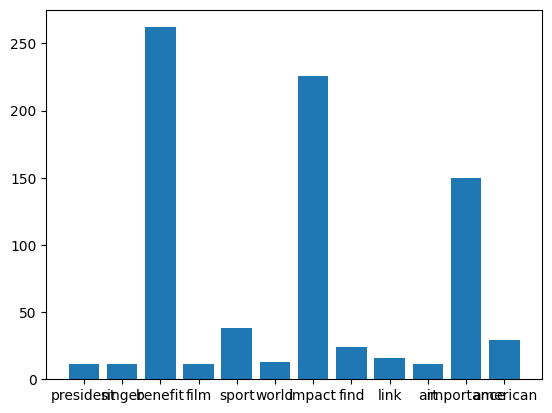

In [21]:
# clusterize sentences based on how they begin
begining_words = [sentence.split()[0] for sentence in X_processed_test]
count_begining_words = {word:begining_words.count(word) for word in set(begining_words)}
# Display histogram of begining words
import matplotlib.pyplot as plt
high_freq_words = {k: v for k, v in count_begining_words.items() if v > 10}
plt.bar(high_freq_words.keys(), high_freq_words.values())
print(high_freq_words)
print(sum(high_freq_words.values()))

We can see that there are many sentences begin by 'benefit' 'impact' and 'importance'. We are going to deal with those first.

## Benefits sentences

In [22]:
benefit_sentences = []
for sentence in X_processed_test:
    if sentence.split()[0] == 'benefit':
        benefit_sentences.append(sentence)

In [24]:
for s in benefit_sentences[:20]:
    print(s)

benefit biomimicry including potential developing sustainable technology improving efficiency
benefit digital fashion fashion including reduced waste improved creativity
benefit organic cotton fashion including reduced pesticide improved sustainability
benefit service learning education including improved civic engagement empathy skill
benefit traveling group including safety cost saving
benefit wind turbine including reduced greenhouse gas emission improved sustainability
benefit 3d printing including improved customization reduced waste
benefit competency based education including improved mastery skill development skill
benefit night sleep overstated
benefit directed learning education including improved discipline responsibility skill
benefit traveling rv including flexibility cost saving
benefit healthy lifestyle reducing risk stroke established
benefit investing managed future diversification established
benefit geothermal energy including reduced greenhouse gas emission improved

We can see that after the main subject there is the word "including" and then many words that would induce error on the classification
Let's drop all th words after including.

In [31]:
processed_benefit_sentences = []
for sentence in benefit_sentences:
    beginning_sentence = sentence.split('including')[0]
    processed_benefit_sentences.append(beginning_sentence.replace('benefit', ''))

In [32]:
for s in processed_benefit_sentences[:20]:
    print(s)

 biomimicry 
 digital fashion fashion 
 organic cotton fashion 
 service learning education 
 traveling group 
 wind turbine 
 3d printing 
 competency based education 
 night sleep overstated
 directed learning education 
 traveling rv 
 healthy lifestyle reducing risk stroke established
 investing managed future diversification established
 geothermal energy 
 regular exercise bone health documented
 sustainable manufacturing practice fashion 
 sustainable textile fashion 
 tidal power 
 eating flexitarian diet 
 eating low salt diet 


## Impact sentences

In [27]:
impact_sentences = []
for sentence in X_processed_test:
    if sentence.split()[0] == 'impact':
        impact_sentences.append(sentence)

In [28]:
for s in impact_sentences[:20]:
    print(s)

impact overpopulation environment topic ongoing research
impact tax reform economy topic ongoing debate
impact demographic change economy topic concern
impact food desert community health topic concern
impact climate change environment topic ongoing scientific research
impact overfishing environment topic ongoing research
impact urban heat island environment topic ongoing research
impact housing market consumer spending topic ongoing debate
impact mining environment topic ongoing concern
impact gig economy cultural travel topic ongoing debate
impact climate change agriculture topic ongoing concern
impact gig economy sustainable travel topic ongoing debate
impact climate change economy increasingly clear
impact digital economy cultural travel topic ongoing debate
impact fashion cultural diversity topic ongoing research
impact climate change human health topic ongoing scientific research
impact automation workforce topic concern
impact market volatility investing topic concern
impact air

In [33]:
processed_impact_sentences = []
for sentence in impact_sentences:
    beginning_sentence = sentence.split('topic')[0]
    processed_impact_sentences.append(beginning_sentence.replace('impact', ''))

In [34]:
for s in processed_impact_sentences[:20]:
    print(s)

 overpopulation environment 
 tax reform economy 
 demographic change economy 
 food desert community health 
 climate change environment 
 overfishing environment 
 urban heat island environment 
 housing market consumer spending 
 mining environment 
 gig economy cultural travel 
 climate change agriculture 
 gig economy sustainable travel 
 climate change economy increasingly clear
 digital economy cultural travel 
 fashion cultural diversity 
 climate change human health 
 automation workforce 
 market volatility investing 
 air pollution human health 
 student loan debt crisis entrepreneurship 


## Importance Sentences

In [35]:
importance_sentences = []
for sentence in X_processed_test:
    if sentence.split()[0] == 'importance':
        importance_sentences.append(sentence)

In [36]:
for s in importance_sentences[:20]:
    print(s)

importance scientific method conducting research overemphasized
importance portion control maintaining healthy weight overemphasized
importance meal planning overemphasized
importance water conservation overstated
importance peer review ensuring quality validity scientific research overstated
importance size inclusivity fashion overstated
importance scientific collaboration addressing global challenge overemphasized
importance food affordability overemphasized
importance extracurricular activity education overemphasized
importance entrepreneurship education education overemphasized
importance biodiversity maintaining ecosystem health overemphasized
importance food justice overstated
importance vegan fashion promoting animal welfare overemphasized
importance environmental education education overstated
importance science advocacy promoting evidence based policy funding overstated
importance scientific reproducibility ensuring reliability research overemphasized
importance cultural compe

In [37]:
processed_importance_sentences = []
for sentence in importance_sentences:
    beginning_sentence = sentence.split('over')[0]
    processed_importance_sentences.append(beginning_sentence.replace('importance', ''))

In [38]:
for s in processed_importance_sentences[:20]:
    print(s)

 scientific method conducting research 
 portion control maintaining healthy weight 
 meal planning 
 water conservation 
 peer review ensuring quality validity scientific research 
 size inclusivity fashion 
 scientific collaboration addressing global challenge 
 food affordability 
 extracurricular activity education 
 entrepreneurship education education 
 biodiversity maintaining ecosystem health 
 food justice 
 vegan fashion promoting animal welfare 
 environmental education education 
 science advocacy promoting evidence based policy funding 
 scientific reproducibility ensuring reliability research 
 cultural competence education education 
 food traceability 
 protecting wetland maintaining water quality 
 protecting growth forest maintaining ecosystem health 


## Preprocessing of beginnings


In [48]:
def process_begining_patterns(sentences):
    begining_words_to_remove = {'benefit':'including', 'impact':'topic', 'importance':'over'}
    processed_sentences = []
    for sentence in sentences:
        any_begining_word = False
        for word in begining_words_to_remove.keys():
            if sentence.split()[0] == word:
                any_begining_word = True
                beginning_sentence = sentence.split(begining_words_to_remove[word])[0]
                processed_sentences.append(beginning_sentence.replace(word, '').strip())
        if not any_begining_word:
            processed_sentences.append(sentence)
            
    return processed_sentences

In [49]:
X_preprocessed_test = process_begining_patterns(X_processed_test)

In [50]:
for s in X_preprocessed_test[:20]:
    print(s)

role credit score lending decision significant
overpopulation environment
scientific method conducting research
startup accelerator funding mentorship early stage company grow
biomimicry
nanotechnology research potential application electronics material science
tax reform economy
demographic change economy
digital fashion fashion
theater company collaborates local school bring art underserved community
portion control maintaining healthy weight
indie film ensemble cast delivers memorable performance resonate audience
latest iphone model feature advanced facial recognition technology
organic cotton fashion
bestselling adapted feature film
service learning education
meal planning
space telescope capture image distant galaxy study formation evolution
water conservation
food desert community health


## Topic name classification

In [51]:
multiple_labels_sentences = []
single_label_sentences = []
for i,sentence in enumerate(X_preprocessed_test):
    identified_labels = []
    for label in labels:
        if labels_processed[label] in sentence:
            identified_labels += [label]
    if len(identified_labels)>1:
        multiple_labels_sentences += [{'text':sentence, 'labels':identified_labels} ]
    elif len(identified_labels) ==1:
        single_label_sentences += [{'text':sentence, 'label':identified_labels[0]} ]


In [52]:
print(len(single_label_sentences))


449


In [54]:
len(multiple_labels_sentences)

43

In [53]:
for s in multiple_labels_sentences:
    print(s)

{'text': 'nanotechnology research potential application electronics material science', 'labels': ['Science', 'Technology']}
{'text': 'food desert community health', 'labels': ['Food', 'Health']}
{'text': 'environmental education education', 'labels': ['Education', 'Environment']}
{'text': 'sport science research center collaborates university cutting edge study', 'labels': ['Science', 'Sports']}
{'text': 'educational technology student outcome', 'labels': ['Education', 'Technology']}
{'text': 'processed food health', 'labels': ['Food', 'Health']}
{'text': 'educational attainment health outcome', 'labels': ['Education', 'Health']}
{'text': 'food waste environment', 'labels': ['Environment', 'Food']}
{'text': 'educational attainment environmental sustainability', 'labels': ['Education', 'Environment']}
{'text': 'food price health', 'labels': ['Food', 'Health']}
{'text': 'sustainable fashion education fashion', 'labels': ['Education', 'Fashion']}
{'text': 'sport science lab conduct resear

In [10]:
classified = [el["text"] for el in multiple_labels_sentences + single_label_sentences]
lefted_sentences = [sentence for sentence in X_processed_test if sentence not in classified]

In [11]:
len(lefted_sentences)

622

benefit investing small cap stock growth established
importance staying hydrated overemphasized
company announced breakthrough quantum computing research
football fanatic tailgated stadium game
benefit investing socially responsible company increasingly clear
benefit thrift shopping including reduced waste improved affordability
investing stock great build wealth time
impact artificial intelligence society topic ongoing scientific research
benefit diversification investing established
tv series finale brought closure fan year anticipation
surfer rode massive wave world famous surf spot
referee made controversial call sparked debate fan
drone delivery service promise fast efficient shipping package
importance scientific integrity promoting public trust accountability overemphasized
benefit geoengineering including potential reducing impact climate change
importance scientific curiosity driving innovation discovery overemphasized
importance scientific collaboration promoting advancement 

In [83]:
synonyms = {
    'education':[],
    'entertainment':['film','movie'],
    'environment':['sustainability','ecosystem','pollution','impact climate'],
    'fashion':[],
    'finance':['market','invest'],
    'food':[],
    'health':[],
    'politics':['political','prime minister'],
    'science':['scientific','scientist'],
    'sport':['player','athlete','football','baseball'],
    'technology':[],
    'travel':[],
}
multiple_labels_sentences_synonymes = []
single_label_sentences_synonymes = []
for i,sentence in enumerate(X_processed_test):
    if i not in stupid_classification:
        identified_labels = []
        for label in labels:
            for synonym in synonyms[label]:
                if synonym in sentence:
                    identified_labels += [label]
                    break
        if len(identified_labels)>1:
            multiple_labels_sentences_synonymes += [{'text':sentence, 'labels':identified_labels} ]
            stupid_classification[index_y[i]]=identified_labels[0]
        elif len(identified_labels) ==1:
            single_label_sentences_synonymes += [{'text':sentence, 'labels':identified_labels} ]
            stupid_classification[index_y[i]]=identified_labels[0]


In [68]:
len(multiple_labels_sentences_synonymes)

7

In [69]:
for el in multiple_labels_sentences_synonymes[:20]:
    print(el["text"])

impact biodiversity loss ecosystem topic ongoing scientific research
impact acid rain ecosystem topic ongoing scientific research
impact desertification ecosystem topic ongoing scientific research
impact invasive specie ecosystem topic ongoing scientific research
impact water pollution aquatic ecosystem topic ongoing scientific research
impact wildfire ecosystem topic ongoing scientific research
impact overfishing marine ecosystem topic ongoing scientific research


In [70]:
len(single_label_sentences_synonymes)

180

In [86]:
for el in single_label_sentences_synonymes[:20]:
    print(el["labels"]," : ",el["text"])

In [72]:
classified = [el["text"] for el in multiple_labels_sentences + single_label_sentences + multiple_labels_sentences_synonymes + single_label_sentences_synonymes]
lefted_sentences = [sentence for sentence in X_processed_test if sentence not in classified]

In [73]:
len(lefted_sentences)

435

In [48]:
for s in lefted_sentences[20:40]:
    print(s)

american heart association recommends diet low sodium reduce risk high blood pressure
reality competition show pit contestant series challenge
benefit night sleep overstated
gymnastics coach guided team victory regional competition
impact automation workforce topic concern
president accused abusing power
cricket bowler delivered fast paced ball caught batsman guard
equestrian rider cleared obstacle precision grace
link stress immune function established
stage play received glowing review innovative staging powerful performance
impact student loan debt crisis entrepreneurship topic concern
benefit geothermal energy including reduced greenhouse gas emission improved energy security
biotech startup developing groundbreaking therapy cancer treatment
impact interest rate economy topic ongoing debate
value dollar fluctuating due economic uncertainty
importance protecting wetland maintaining water quality overemphasized
autonomous vehicle industry poised rapid growth coming year
impact gig ec

In [358]:
df_ref.head()

,text,label
0,The indie film's ensemble cast delivers memora...,Entertainment
1,The bestselling novel is being adapted into a ...,Entertainment
2,The impact of climate change on the environmen...,Environment
3,The film director's visionary approach to stor...,Entertainment
4,The indie film gained a cult following for its...,Entertainment


In [79]:
final_submission = pd.read_csv('data/submission_bert.csv')
records = final_submission.to_dict('records')
count = 0

for record in records:
    if record["ID"] in stupid_classification:
        if record["Label"]!= label_mapping[stupid_classification[record["ID"]]]:
            count += 1
        record["Label"] = label_mapping[stupid_classification[record["ID"]]]

In [80]:
final_submission = pd.DataFrame(records)
final_submission.to_csv('data/submission_bert_and_postprocessing.csv',index=False)

In [19]:
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=12)
clusterer.fit(X_test)


KMeans(n_clusters=12)

In [20]:
labels = clusterer.labels_

In [21]:
df_test["clustering_label"] = labels

In [23]:
df_test.groupby("clustering_label",as_index=False).agg(
    texts = ("text",list)
)

,clustering_label,texts
0,0,[The importance of the scientific method in co...
1,1,[The impact of tax reform on the economy is a ...
2,2,"[The benefits of biomimicry are many, includin..."
3,3,[The Supreme Court has ruled in favor of the p...
4,4,[The benefits of investing in managed futures ...
5,5,[The impact of overpopulation on the environme...
6,6,[The benefits of a service-learning education ...
7,7,[The benefits of using digital fashion in fash...
8,8,[The best way to find the best local parks is ...
9,9,[The political climate is becoming increasingl...


In [25]:
label = 0
for sentence in df_test[df_test.clustering_label == label].text.values[:20]:
    print(sentence)

The importance of the scientific method in conducting research cannot be overemphasized.

The importance of portion control in maintaining a healthy weight cannot be overemphasized.

The importance of meal planning cannot be overemphasized.

The importance of water conservation cannot be overstated.

The importance of peer review in ensuring the quality and validity of scientific research cannot be overstated.

The importance of size inclusivity in fashion cannot be overstated.

The importance of scientific collaboration in addressing global challenges cannot be overemphasized.

The importance of food affordability cannot be overemphasized.

The importance of extracurricular activities in education cannot be overemphasized.

The benefits of a good night's sleep cannot be overstated.

The importance of entrepreneurship education in education cannot be overemphasized.

The importance of biodiversity in maintaining ecosystem health cannot be overemphasized.

The importance of food justice

In [4]:
X_train = df_train['text'].values.tolist()
y_train = df_train['label'].values.tolist()
X_train = encoder.fit_transform(X_train)
X_test = df_test['text'].values.tolist()
y_test = df_test['label'].values.tolist()
X_test = encoder.transform(X_test)

100%|██████████| 1140/1140 [00:43<00:00, 26.37it/s]


In [6]:
# X_train = encoder.fit_transform(X_processed_train)
X_train = encoder.fit_transform(X_processed_train)

  9%|▉         | 70/752 [00:02<00:27, 24.63it/s]


KeyboardInterrupt: 

In [5]:
classifier.train_classifier(X_train, y_train, tune_hyperparameters=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.6s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.3s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END ................C=100, penalty=l1, solver=liblinear; total time=   0.7s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=   1.4s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=   1.1s
[CV] END .................C=10, penalty=l1, solv

In [7]:
X_test = encoder.transform(X_test)


  0%|          | 0/1140 [00:00<?, ?it/s]


ValueError: text input must be of type `str` (single example), `List[str]` (batch or single pretokenized example) or `List[List[str]]` (batch of pretokenized examples).

In [8]:
_, class_report, confusion_matrix = classifier.evaluate_classifier(X_test, y_test)

Accuracy: 0.66


In [9]:
print(class_report)

               precision    recall  f1-score   support

    Education       0.73      0.72      0.73        97
Entertainment       0.98      0.60      0.75        96
  Environment       0.72      0.80      0.76       171
      Fashion       0.77      0.54      0.64       105
      Finance       0.84      0.51      0.64        82
         Food       0.15      0.38      0.21        24
       Health       0.79      0.70      0.75       165
     Politics       0.50      0.88      0.63       119
      Science       0.71      0.38      0.50        76
       Sports       0.66      0.62      0.64        47
   Technology       0.50      0.72      0.59        75
       Travel       0.74      0.54      0.62        83

     accuracy                           0.66      1140
    macro avg       0.67      0.62      0.62      1140
 weighted avg       0.72      0.66      0.66      1140



<Axes: >

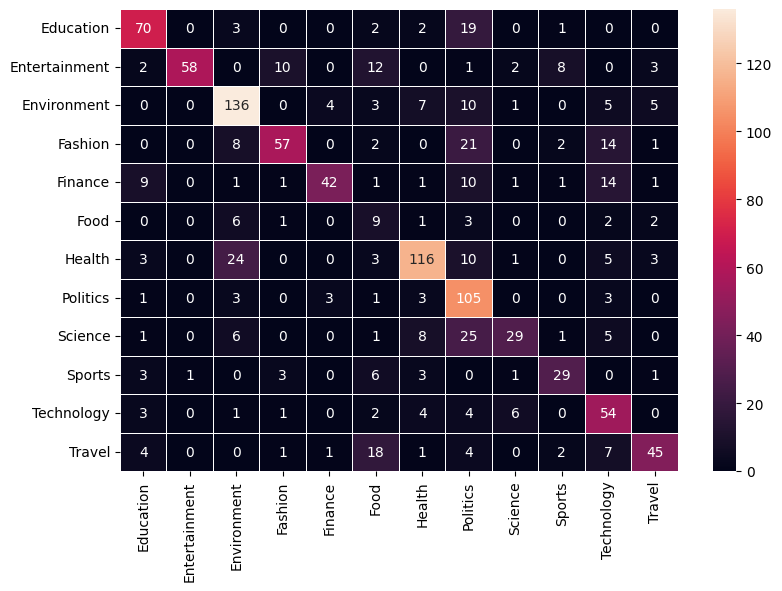

In [10]:
# Display confusion matrix with all the annotations
import seaborn as sns
import matplotlib.pyplot as plt

f, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", linewidths=.5, ax=ax, xticklabels=classifier.classifier.classes_, yticklabels=classifier.classifier.classes_)



In [43]:
test_predictions = classifier.predict(X_test)

In [45]:
pd.DataFrame({"ID":list(range(len(test_predictions))),"Label":list(test_predictions)}).to_csv("data/submission_tfidf.csv", index=False)